# Holocene Ice , Based on Sigl et al., 2013

#### Importing packages 

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scipy
import warnings 
from tabulate import tabulate
from scipy import interpolate
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import seaborn as sns
from matplotlib import style
import matplotlib.font_manager
from scipy.stats.stats import pearsonr
from itertools import zip_longest

np.set_printoptions(threshold=np.inf)
sns.set_theme(context='paper', style='white', palette='colorblind',font='helvetica')

#### Data from Sigl et al. 2013

In [2]:
sheet = pd.ExcelFile('Sigl_et_al_JGR_2013_data.xls')

sigletal = pd.read_excel(sheet, 'NEEM_2011_S1_JGR_data')
sheet2 = pd.ExcelFile('sigletal2013_results.xlsx')

results = pd.read_excel(sheet2, 'Sheet1')

#### Arrays with data 

In [3]:
## Pandas to array ## 

NEEM = np.array(sigletal) #all NEEM data
results=np.array(results) #all results from Sigl et al. (2013)

## Flip the arrays ##

years = np.flip(NEEM[:,0]) #years array
nssS = np.flip(NEEM[:,1]) #nssS concentration array
depth= np.flip(NEEM[:,2]) #depth array
depth_mweq = np.flip(NEEM[:,3]) #depth of water equivalent meters 
thickness = depth[:-1] - depth[1:] #thickness array

## Results from Sigl et al. (2013) ## 

sulfate_dep_sigl = results[:,6] # sigl et al. sulfate deposition 
year_sigl = results[:,4] # sigl et al. eruption years

## Sulfate fluxes calculated using fast ion chromatography SO4 are
## taken away since comparing those will lead to inaccurate results

for i in range(len(sulfate_dep_sigl)):
    if year_sigl[i] == '1110.7':
        sulfate_dep_sigl[i] = np.nan
    if year_sigl[i] == '539.5':
        sulfate_dep_sigl[i] = np.nan  
    if year_sigl[i] == '529.8':
        sulfate_dep_sigl[i] = np.nan 
    if year_sigl[i] == '515.5':
        sulfate_dep_sigl[i] = np.nan
    else:
        continue

## Annual array ## 

NEEM_annual = np.arange(78,1998,1) 

## Checking that the arrays seen reasonable ## 

headers=('Array', 'First year', 'Last year')
first_column = np.array(['NEEM annual', 'NEEM years', 'NEEM thickness', 'NEEM depth'])
second_column = np.array([NEEM_annual[0], years[0], thickness[0], depth[0]])
third_column = np.array([ NEEM_annual[-1], years[-1], thickness[-1], depth[-1]])
table = zip(first_column, second_column, third_column)
print(tabulate(table, headers=headers, floatfmt=".3f"))

Array             First year    Last year
--------------  ------------  -----------
NEEM annual           78.000     1997.000
NEEM years            78.208     1997.458
NEEM thickness         0.015        0.045
NEEM depth           410.837        6.029


#### Sulfate deposition Sigl et al. 2013

In [4]:
## Annual years array ## 

NEEM_annual = np.arange(78,1998,1) 

## Empty arrays to be filled in ## 

sulfate_dep_sigl2= []
year_sigl2= []

## Taking away the error margins from the Sigl et al. data ## 

for i in range(1,len(sulfate_dep_sigl)):
    if pd.isnull(sulfate_dep_sigl[i]):
        continue
    else:
        if len(sulfate_dep_sigl[i][:]) <=9: 
            sulfate_dep_sigl2.append(sulfate_dep_sigl[i][:3])
            year_sigl2.append(year_sigl[i])
        else:
            sulfate_dep_sigl2.append(sulfate_dep_sigl[i][:4])
            year_sigl2.append(year_sigl[i])
            
## Replacing some arrays that look a bit funny ## 

sulfate_dep_sigl2 = [s.replace('178.', '178.6') for s in sulfate_dep_sigl2]
sulfate_dep_sigl2 = [s.replace('8.8\u2009', '8.8') for s in sulfate_dep_sigl2]

#### 1. Annualy averaging and annual thickness

In [5]:
### creating empty arrays ###

nssS_annual = []
depth_annual = []
thickness_annual = []

### 1. Annualy averaging ### 

for i in range(len(NEEM_annual)-1):
    
    index = np.where((years > NEEM_annual[i]+0) & (years < NEEM_annual[i]+1))
    
    if nssS[index].size == 0: 

        nssS_annual.append(np.nan)
        thickness_annual.append(np.nan)
        depth_annual.append(np.nan)

    else:
    #with warnings.catch_warnings(): ## ignoring warning of empty element nanmean ##
        #warnings.simplefilter("ignore", category=RuntimeWarning)
        nssS_annual.append(np.nanmean(nssS[index]))
        thickness_annual.append(np.nansum(thickness[index]))
        depth_annual.append(np.nanmean(depth[index]))

#### Plotting the raw and annual nssS concentration 

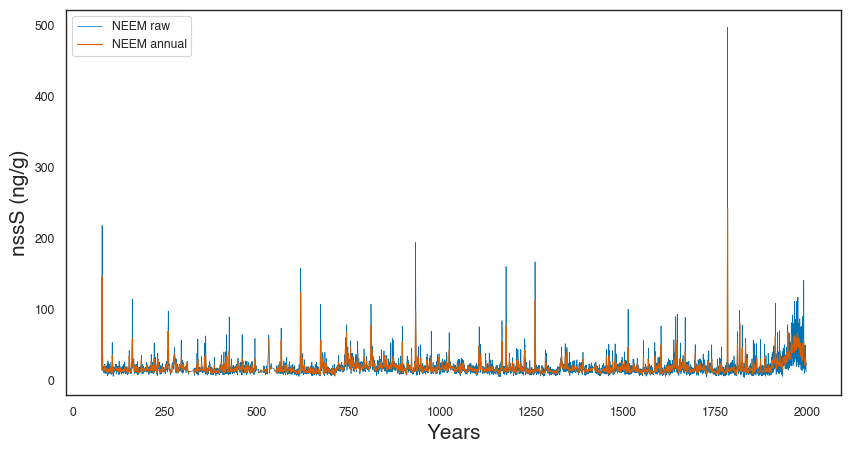

In [6]:
## New annual years array starting at the middle of each year ## 

NEEM_annual = np.arange(78.5,1997.5,1)

#Plotting the raw and annual nssS concentration ## 

plt.figure(figsize=(10,5))
plt.plot(years, nssS, 'b',linewidth=0.5, markersize=1 ,label='NEEM raw')
plt.plot(NEEM_annual, nssS_annual, 'r', linewidth=0.8, label='NEEM annual')
plt.xlabel('Years', fontsize=15)
plt.ylabel('nssS (ng/g)', fontsize=15)
plt.legend()
plt.show()

#### 2. Interpolation of the missing data (nssS values) 

In [7]:
### Creating arrays that we need ###

#NEEM_annual = np.reshape(NEEM_annual,(len(NEEM_annual),))
#nssS_annual = np.reshape(nssS_annual,(len(nssS_annual),))
#nssS_annual_interp = np.copy(nssS_annual)

### 2. Interpolation of the missing data ###
#nssS_nan = ~np.isnan(nssS_annual_interp)
#idx_nonzero = nssS_nan.ravel().nonzero()[0] #flattens the array and returns the indices that are nonzero 
#nssS_y = nssS_annual_interp[~np.isnan(nssS_annual_interp)] #y-coordinates of the data points 
#x  = np.isnan(nssS_annual_interp).ravel().nonzero()[0] #x-coordinates that evaluates interpolation 
#nssS_annual_interp[np.isnan(nssS_annual_interp)] = np.interp(x, idx_nonzero, nssS_y) #interpolating the data 

#### Interpolation of the missing data (thickness values) 

In [8]:
### Creating arrays that we need ###

thickness_annual = np.reshape(thickness_annual,(len(nssS_annual),))
#thickness_annual_interp = np.copy(thickness_annual)

### 2. Interpolation of the missing data ###
#thickness_nan = ~np.isnan(thickness_annual_interp)
#idx_nonzero = thickness_nan.ravel().nonzero()[0] #flattens the array and returns the indices that are nonzero 
#thickness_y =thickness_annual_interp[~np.isnan(thickness_annual_interp)] #y-coordinates of the data points 
#x  = np.isnan(thickness_annual_interp).ravel().nonzero()[0] #x-coordinates that evaluates interpolation 
#thickness_annual_interp[np.isnan(thickness_annual_interp)] = np.interp(x, idx_nonzero, thickness_y) #interpolating the data 

#### Plot of the interpolation of the missing nssS data

In [9]:
#plt.figure(figsize=(10,5))
#plt.plot(NEEM_annual, nssS_annual_interp, linewidth=0.8, linestyle='-',color='r', label='NEEM interpolation')
#plt.plot(NEEM_annual, nssS_annual, 'b.', markersize=1.5, label='NEEM annual')
#plt.xlabel('Years', fontsize=15)
#plt.ylabel('nssS (ng/g)', fontsize=15)
#plt.legend()
#plt.show()

#### 3. 31-year running median filter (RM) 

In [10]:
RM = np.zeros(len(NEEM_annual))
nssS_annual = np.array(nssS_annual)
#RM = scipy.signal.medfilt(nssS_annual_interp, kernel_size=31) ## just to compare
for i in range(len(NEEM_annual)):
    idx = np.where((NEEM_annual[:]> NEEM_annual[i]-16) & (NEEM_annual[:]<NEEM_annual[i]+16) & (~np.isnan(NEEM_annual[:])))
    RM[i] = np.nanmedian(nssS_annual[idx])

#### MAD (median absolute deviation) 

In [11]:
#median_value = np.median(nssS_annual_interp)
#MAD = np.median([np.abs(number - rm) for number in nssS_annual_interp])

MAD = scipy.stats.median_abs_deviation(nssS_annual, nan_policy='omit')
z=3 #detection limit 3*MAD over the running median 
y =z*MAD + RM #volcanic detection limit 

#### Plotting the RM and MAD 

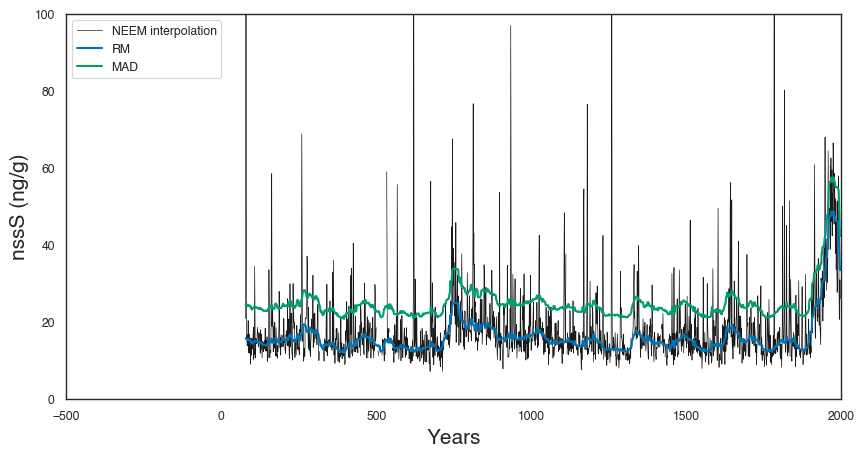

In [12]:
plt.figure(figsize=(10,5))
plt.plot(NEEM_annual, nssS_annual, linewidth=.5, linestyle='-',color='k', label='NEEM interpolation')
plt.plot(NEEM_annual, RM, linewidth=1.5, label='RM')
plt.plot(NEEM_annual, y, linewidth=1.5, color= 'g', label='MAD')
plt.xlabel('Years', fontsize=15)
plt.ylabel('nssS (ng/g)', fontsize=15)
plt.xlim(-500,2000)
plt.ylim(0,100)
plt.legend()
plt.show()

#### 4. Exclude volcanic signals 

In [13]:
## Empty lists to contain detected volcanic eruptions ## 

eruptions = []
eruption_year = []

## if diff > 0, there was a volcanic eruption
diff = nssS_annual - y

for i in range(len(diff)):
    if diff[i] > 0:
        eruptions.append(diff[i])
        eruption_year.append(NEEM_annual[i])
    else:
        continue

#### Running median filter without the influence of volcanism 

In [14]:
nssS_annual_mod = np.copy(nssS_annual) #copy of the annual sulfur concentration

### Taking away influence of volcanism ###

for i in range(len(diff)):
    if nssS_annual[i] > y[i]:
        nssS_annual_mod[i] = np.nan
    else:
        continue
        
### interpolating the data without volcanism ###
        
#nssS_annual_mod = np.reshape(nssS_annual_mod,(len(nssS_annual_mod),))
#nssS_annual_interp_mod = np.copy(nssS_annual_mod)

#nssS_nan = ~np.isnan(nssS_annual_interp_mod)
#idx_nonzero = nssS_nan.ravel().nonzero()[0] #flattens the array and returns the indices that are nonzero 
#nssS_y = nssS_annual_interp_mod[~np.isnan(nssS_annual_interp_mod)] #y-coordinates of the data points 
#x  = np.isnan(nssS_annual_interp_mod).ravel().nonzero()[0] #x-coordinates that evaluates interpolation 
#nssS_annual_interp_mod[np.isnan(nssS_annual_interp_mod)] = np.interp(x, idx_nonzero, nssS_y) #interpolating the data 

### Running median on data without volcanism ###

RM_new = np.zeros(len(NEEM_annual))
#RM_new = scipy.signal.medfilt(nssS_annual_interp, kernel_size=31) ## just to compare

for i in range(len(NEEM_annual)):
    idx = np.where((NEEM_annual[:]> NEEM_annual[i]-16) & (NEEM_annual[:]<NEEM_annual[i]+16) & (~np.isnan(NEEM_annual[:])))
    RM_new[i] = np.nanmedian(nssS_annual_mod[idx])
    
#median_value = np.median(nssS_annual_interp_mod)
#MAD_new = np.median([np.abs(number-RM_new) for number in nssS_annual_interp_mod])
    
MAD_new = scipy.stats.median_abs_deviation(nssS_annual_mod, nan_policy='omit')
z=3
y_new =z*MAD_new + RM_new

#### Plotting the data compared to Sigl et al (2013)

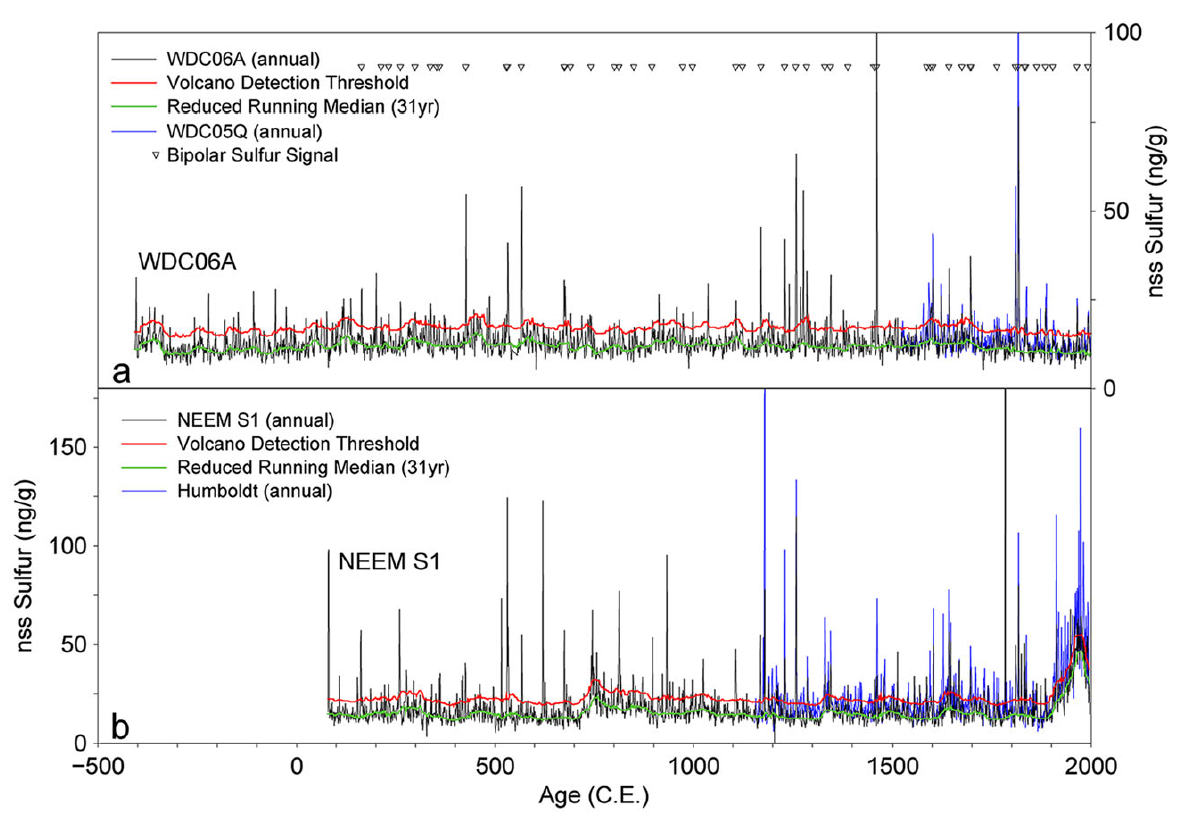

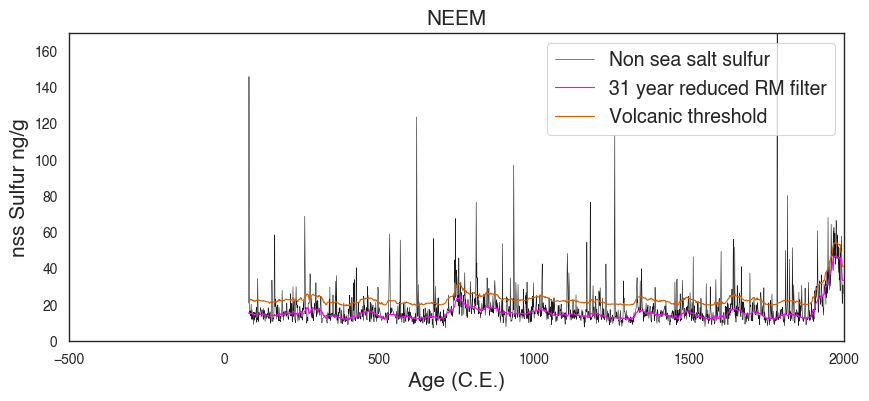

<Figure size 640x480 with 0 Axes>

In [15]:
NEEM_annual = np.arange(78.5,1997.5,1)
plt.figure(figsize=(10,4))
#plt.plot(years, nssS, 'b',linewidth=0.5, markersize=1 ,label='NEEM raw')
plt.plot(NEEM_annual[~np.isnan(nssS_annual)], nssS_annual[~np.isnan(nssS_annual)], color='k', label = 'Non sea salt sulfur', linewidth=0.4)
plt.plot(NEEM_annual, RM_new, 'magenta', linewidth=0.8, label = '31 year reduced RM filter')
plt.plot(NEEM_annual, y_new,'r', linewidth=0.8, label = 'Volcanic threshold')
plt.title('NEEM', fontsize=15)
plt.xlabel('Age (C.E.)', fontsize=15)
plt.ylabel('nss Sulfur ng/g', fontsize=15)
plt.ylim(0,170)
plt.xlim(-500,2000)
plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=10)
plt.show()
plt.savefig('WDC06A.png')

In [16]:
#NEEM_annual = np.arange(78.5,1997.5,1)
#plt.figure(figsize=(10,4))
#plt.plot(years, nssS, color='k', linewidth = 0.4, label = 'NEEM monthly')
#plt.plot(NEEM_annual, nssS_annual_interp, 'k',linewidth=1.2, label = 'NEEM annual')
#plt.plot(NEEM_annual, y_new,'k--', label = 'volcanic detection')
#plt.title('NEEM', fontsize=15)
#plt.xlabel('Year', fontsize=15)
#plt.ylabel('nssS_ng/g', fontsize=15)
#plt.ylim(0,90)
#plt.xlim(150,270)
#plt.legend()
#plt.show()


#### Integrating the volcanic peaks --> sulfate deposition 


In [17]:
#checking the length of the arrays and the values. 
print('Length of the arrays:')
print('Length NEEM annual =', len(NEEM_annual), 'Length nssS interp =', len(nssS_annual), 'Length y new =', len(y_new))
print('First and last values of the arrays:')
print('NEEM annual:', NEEM_annual[0], NEEM_annual[-1])
print('nssS annual:', nssS_annual[0],  nssS_annual[-1])
print('y new:', y_new[0], y_new[-1])

Length of the arrays:
Length NEEM annual = 1919 Length nssS interp = 1919 Length y new = 1919
First and last values of the arrays:
NEEM annual: 78.5 1996.5
nssS annual: 20.862500000000004 26.118916666666667
y new: 22.949458333333336 40.87558333333334


#### Calculating the sulfate deposition

In [18]:

## empty arrays to be filled in ## 
sulfate = []
sulfate_dep = []
year = []
first_year = []
last_year = []

for i in range(len(NEEM_annual)):
    
    if NEEM_annual[i] == 1919.5:
        idx_1 = np.where(NEEM_annual == 1919.5)
        sulfate.append((nssS_annual[idx_1] - RM_new[idx_1]) * 3 * 1e-3 * 917 * thickness_annual[idx_1])
        year.append(NEEM_annual[i])
    
    if (nssS_annual[i] > y_new[i]) & (NEEM_annual[i] != 1919.5): #detecting volcanic eruptions and integrating
        sulfate.append((nssS_annual[i] - RM_new[i]) * 3 * 1e-3 * 917 * thickness_annual[i])
        year.append(NEEM_annual[i])
        continue
        
    else: 
        if len(sulfate) != 0:
            sulfate_dep.append(np.sum(sulfate))
            first_year.append(year[0])
            last_year.append(year[-1])
            sulfate = []
            year = []
    
        else:
            sulfate=[]
            year = []
        

In [19]:

## taking away "insignificant" volcanic eruptions that are too small to detect 

sulfate_dep = np.array(sulfate_dep)
sulfate_dep_2 = []
first_year_2 = []

for i in range(len(first_year)):
    #print(sulfate_dep[i-1], first_year[i-1])
    #print(first_year[i], sulfate_dep[i])
    #if sulfate_dep[i] <5: #if the sulfate deposition is less, the resutlts might be insignificant
        #print(first_year[i-1])
        #continue 
 
        #if np.abs(first_year[i-1] - first_year[i]) <= 2: 
            #print(first_year[i-1])
         #   sulfate_dep_2.append(sulfate_dep[i-1]+sulfate_dep[i])
          #  first_year_2.append(first_year[i-1])
    #else:
        #print(first_year[i],sulfate_dep[i])
    sulfate_dep_2.append(sulfate_dep[i])
    first_year_2.append(first_year[i])   
            #print(first_year[i-1])
 
#print(len(sulfate_dep_sigl2), len(sulfate_dep_2))


In [20]:
## comparing the results with sigl et al 2013 ## 
#header = ('year', 'SO4-2', 'year sigl', 'SO4-2 sigl')
#table = zip(np.flip(first_year_2), np.flip(sulfate_dep_2), year_sigl2, sulfate_dep_sigl2)
#print(tabulate(table, headers=header, floatfmt=".4f"))

154


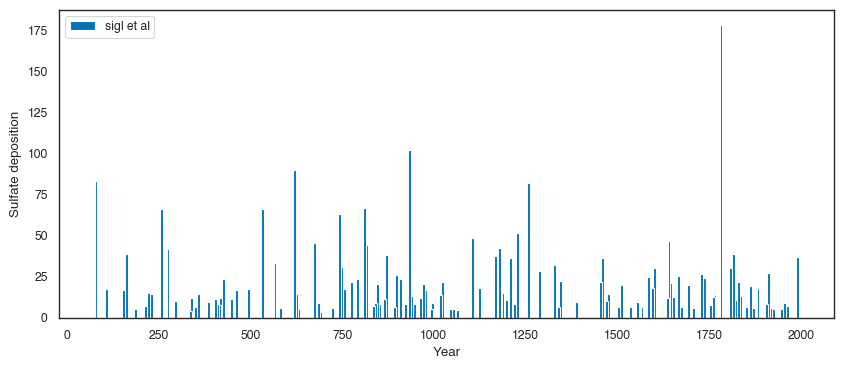

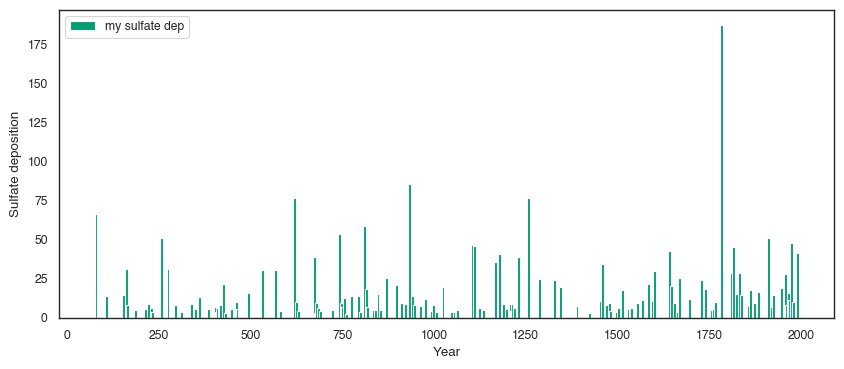

In [21]:
## plotting our results against sigl et al 2013 ##
year_sigl2 = [float(x) for x in year_sigl2]

sulfate_dep_sigl2 = [float(x) for x in sulfate_dep_sigl2]

sulfate_dep_sigl2 = np.array(sulfate_dep_sigl2)
sulfate_dep_2 = np.array(sulfate_dep_2)

first_year_2 = np.array(first_year_2)

print(len(sulfate_dep_2[sulfate_dep_2 > 0] ))
#print(len(sulfate_dep_2[sulfate_dep_2 > 10]))

plt.figure(figsize=(10,4))

plt.bar(year_sigl2, sulfate_dep_sigl2, label ='sigl et al', width=8.0)
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Sulfate deposition')

plt.figure(figsize=(10,4))
plt.bar(first_year_2[sulfate_dep_2>0], sulfate_dep_2[sulfate_dep_2>0], label='my sulfate dep',color='g', linestyle='-', width=8.0)
#color=(0.1, 0.1, 0.1, 0.1),edgecolor='g', linestyle='-', width=3.0
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Sulfate deposition')
plt.show()

#### Making sure the correct years are matching between the data sets 

In [22]:

y_sigl = np.copy(year_sigl2)
y_mydata = []
s_sigl = np.copy(sulfate_dep_sigl2)
s_mydata = []

first_year_2_flip = np.array(np.flip(first_year_2))
sulfate_dep_2_flip = np.flip(sulfate_dep_2)
year_sigl2 = np.array(year_sigl2)
sulfate_dep_sigl2 = np.array(sulfate_dep_sigl2)
year_sigl2[year_sigl2 == 1918] = 1919
 
#print(sulfate_dep_sigl2[sulfate_dep_sigl2 > 150])

for i in range(len(year_sigl2)):
    idx = np.where( np.abs(year_sigl2[i] - first_year_2_flip) < 1.5)
    s_mydata.append(sulfate_dep_2_flip[idx])
    y_mydata.append(first_year_2_flip[idx])
    
s_mydata = [item for sublist in s_mydata for item in (sublist or [0])]
y_mydata = [item for sublist in y_mydata for item in(sublist or [0])]

s_mydata = np.array(s_mydata)
y_mydata = np.array(y_mydata)

header = ('year', 'SO4-2', 'year sigl', 'SO4-2 sigl')

table = zip_longest(y_mydata, s_mydata, y_sigl, s_sigl)

print(tabulate(table, headers=header, floatfmt=".4f"))

print(len(y_mydata), len(y_sigl))
    

     year     SO4-2    year sigl    SO4-2 sigl
---------  --------  -----------  ------------
1990.5000   41.7550    1991.7000       37.2000
1964.5000   13.6245    1963.9000        7.2000
1957.5000   27.9303    1957.0000        8.8000
1947.5000   19.1351    1946.8000        5.2000
1925.5000   14.5803    1924.9000        5.7000
1919.5000    7.2893    1918.0000        5.9000
1911.5000   51.1766    1912.8000       27.6000
1908.5000   12.4484    1908.0000        8.6000
1884.5000   16.7386    1883.6000       18.5000
1873.5000    9.8689    1872.6000        6.2000
1862.5000   18.1557    1862.0000       19.3000
1856.5000    7.5424    1856.2000        7.4000
1853.5000    8.3540    1853.4000        6.5000
1836.5000   14.5386    1835.7000       13.1000
1831.5000   29.0703    1831.4000       21.9000
1823.5000   15.0382    1822.8000       10.8000
1816.5000   45.3967    1815.6000       39.0000
1810.5000   28.6818    1809.7000       30.6000
1783.5000  187.9646    1782.8000      178.6000
1766.5000   1

/var/folders/st/s794rfks0m1cxyggxfnyq21r0000gn/T/ipykernel_20872/2861540453.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  s_mydata = [item for sublist in s_mydata for item in (sublist or [0])]
/var/folders/st/s794rfks0m1cxyggxfnyq21r0000gn/T/ipykernel_20872/2861540453.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  y_mydata = [item for sublist in y_mydata for item in(sublist or [0])]


In [23]:
header = ('year', 'SO4-2', 'year sigl', 'SO4-2 sigl')
table = zip_longest(first_year_2_flip[sulfate_dep_2_flip > 5],sulfate_dep_2_flip[sulfate_dep_2_flip > 5], year_sigl2, sulfate_dep_sigl2)
print(tabulate(table, headers=header))

  year      SO4-2    year sigl    SO4-2 sigl
------  ---------  -----------  ------------
1990.5   41.755         1991.7          37.2
1988.5    8.47565       1963.9           7.2
1978.5    9.90519       1957             8.8
1973.5   47.8797        1946.8           5.2
1969.5   11.3827        1924.9           5.7
1966.5   15.8641        1919             5.9
1964.5   13.6245        1912.8          27.6
1960.5    8.02887       1908             8.6
1957.5   27.9303        1883.6          18.5
1947.5   19.1351        1872.6           6.2
1944.5    5.71295       1862            19.3
1925.5   14.5803        1856.2           7.4
1919.5    7.28927       1853.4           6.5
1911.5   51.1766        1835.7          13.1
1908.5   12.4484        1831.4          21.9
1904.5   12.3798        1822.8          10.8
1884.5   16.7386        1815.6          39
1873.5    9.86894       1809.7          30.6
1862.5   18.1557        1782.8         178.6
1856.5    7.54236       1766.4          13.8
1853.5    8.

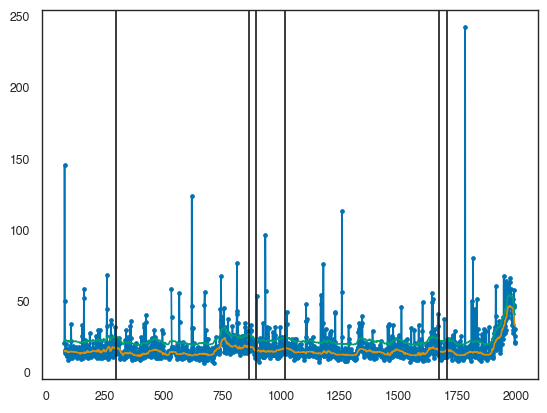

In [24]:
plt.figure()
plt.plot(NEEM_annual, nssS_annual, '-', marker='.')
plt.plot(NEEM_annual, RM_new)
plt.plot(NEEM_annual, y_new)
for i in range(len(y_sigl[y_mydata==0])):
    plt.axvline(x=y_sigl[y_mydata==0][i], ymin=0, ymax=1, c='k')
#plt.xlim(890,895)
#plt.ylim(0,50)
plt.show()

#### Linear Regression

In [25]:
## linear regression between the two results to see how significant similar they are ## 
from sklearn.linear_model import LinearRegression
corr = pearsonr(s_sigl , s_mydata)

print(np.shape(s_mydata), np.shape(s_sigl))

## coefficiant of determination ## 
s_sigl = np.array(s_sigl).reshape((-1,1))
s_mydata = np.array(s_mydata).reshape((-1,1))

model = LinearRegression().fit(s_sigl , s_mydata)
r_sq = model.score(s_sigl,s_mydata)

print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

xx = np.arange(-5,201,1)
yy = xx * model.coef_  + model.intercept_
yy = yy.reshape((206,))

(128,) (128,)
coefficient of determination: 0.8951999932038195
intercept: [-1.86334325]
slope: [[0.91056673]]


In [26]:
print("correlation =", corr[0], "p-value = ", corr[1])

correlation = 0.946150090209698 p-value =  1.4364791619454788e-63


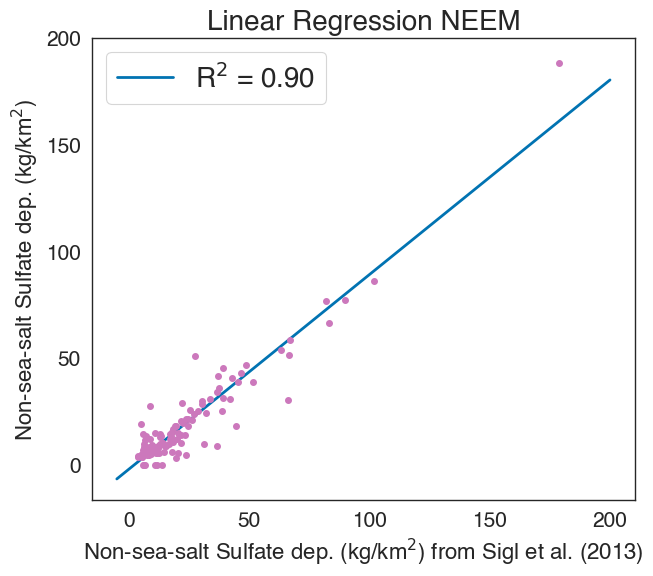

In [27]:
xticks = [0,50,100, 150, 200]
yticks= [0,50,100, 150, 200]

plt.figure(figsize=(7,6))
plt.plot(xx,yy, 'b', label = f'R$^2$ = {np.round(r_sq,2)}0', linewidth=2.)
plt.plot(s_sigl, s_mydata, 'm.', markersize=8)
plt.xlabel('Non-sea-salt Sulfate dep. (kg/km$^2$) from Sigl et al. (2013)', fontsize=16)
plt.ylabel('Non-sea-salt Sulfate dep. (kg/km$^2$) ', fontsize=16)
plt.title('Linear Regression NEEM', fontsize=20)
plt.xticks(xticks, xticks, fontsize=15)
plt.yticks(yticks, yticks, fontsize=15)
plt.legend(fontsize=20)
#plt.xlim(0,200)
#plt.ylim(0,200)
plt.savefig('LR_NEEM.jpg', dpi=1000, bbox_inches='tight')
plt.show()